In [75]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_score
from sklearn import tree

import pydotplus
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import sqlite3

from __future__ import division
from datetime import datetime
%matplotlib inline

In [2]:
data= pd.read_csv("EEG data.csv")
col_headings =["Subject ID","Video ID","Attention","Mediation","Raw","Delta","Theta","Alpha1","Alpha2",
                    "Beta1","Beta2","Gamma1","Gamma2","expectconfusion","userconfusion"]
data.columns = col_headings 
data.tail()

,Subject ID,Video ID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,expectconfusion,userconfusion
12805,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12806,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12807,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0
12809,9.0,9.0,64.0,29.0,-49.0,1164555.0,1184366.0,50014.0,124208.0,10634.0,445383.0,22133.0,4482.0,1.0,0.0


In [3]:
#subject ID, age, ethnicity, gender
eeg_meta = [0,25,"Han Chinese","M",
1,24,"Han Chinese","M",
2,31,"English","M",
3,28,"Han Chinese","F",
4,24,"Bengali","M",
5,24,"Han Chinese","M",
6,24,"Han Chinese","M",
7,25,"Han Chinese","M",
8,25,"Han Chinese","M",
9,24,"Han Chinese","F"]

In [ ]:
Column 1: Subject ID
Column 2: Video ID
Column 3: Attention (Proprietary measure of mental focus)
Column 4: Mediation (Proprietary measure of calmness)
Column 5: Raw (Raw EEG signal)
Column 6: Delta (1-3 Hz of power spectrum)
Column 7: Theta (4-7 Hz of power spectrum)
Column 8: Alpha 1 (Lower 8-11 Hz of power spectrum)
Column 9: Alpha 2 (Higher 8-11 Hz of power spectrum)
Column 10: Beta 1 (Lower 12-29 Hz of power spectrum)
Column 11: Beta 2 (Higher 12-29 Hz of power spectrum)
Column 12: Gamma 1 (Lower 30-100 Hz of power spectrum)
Column 13: Gamma 2 (Higher 30-100 Hz of power spectrum)
Column 14: predefined label (whether the subject is expected to be confused)
Column 15: user-defined label (whether the subject is actually confused)

## EDA 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 15 columns):
Subject ID         12810 non-null float64
Video ID           12810 non-null float64
Attention          12810 non-null float64
Mediation          12810 non-null float64
Raw                12810 non-null float64
Delta              12810 non-null float64
Theta              12810 non-null float64
Alpha1             12810 non-null float64
Alpha2             12810 non-null float64
Beta1              12810 non-null float64
Beta2              12810 non-null float64
Gamma1             12810 non-null float64
Gamma2             12810 non-null float64
expectconfusion    12810 non-null float64
userconfusion      12810 non-null float64
dtypes: float64(15)
memory usage: 1.5 MB


In [87]:
data.iloc[:,2:].describe()

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,expectconfusion,userconfusion
count,12810.000000,12810.000000,12810.000000,1.281000e+04,1.281000e+04,1.281000e+04,1.281000e+04,1.281000e+04,1.281000e+04,1.281000e+04,1.281000e+04,12810.000000,12810.000000
mean,41.312724,47.182982,65.554176,6.058090e+05,1.680586e+05,4.138495e+04,3.318411e+04,2.431809e+04,3.814379e+04,2.959227e+04,1.441645e+04,0.480016,0.512646
std,23.153493,22.656830,597.941429,6.376428e+05,2.441431e+05,7.243361e+04,5.831632e+04,3.838117e+04,7.906912e+04,7.982948e+04,3.603660e+04,0.499620,0.499860
min,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,27.000000,37.000000,-14.000000,9.806200e+04,2.691475e+04,6.838000e+03,6.851500e+03,6.139000e+03,7.358250e+03,4.057500e+03,2.167250e+03,0.000000,0.000000
50%,43.000000,51.000000,35.000000,3.955615e+05,8.130750e+04,1.748700e+04,1.495500e+04,1.281650e+04,1.580850e+04,9.757000e+03,5.115500e+03,0.000000,1.000000
75%,57.000000,63.000000,90.000000,9.166485e+05,2.052930e+05,4.478425e+04,3.455525e+04,2.739850e+04,3.549300e+04,2.487975e+04,1.267175e+04,1.000000,1.000000
max,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [86]:
data.iloc[:,2:].corr()

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,expectconfusion,userconfusion
Attention,1.000000,0.548625,-0.094952,-0.220384,-0.258345,-0.198660,-0.247007,-0.255370,-0.306633,-0.299910,-0.312731,0.001607,-0.119044
Mediation,0.548625,1.000000,-0.106919,-0.111818,-0.179893,-0.043277,-0.153742,-0.240773,-0.391365,-0.344922,-0.373256,0.015737,-0.023518
Raw,-0.094952,-0.106919,1.000000,0.048922,0.053452,0.045250,0.063872,0.090861,0.173629,0.186884,0.205778,0.010625,-0.001436
Delta,-0.220384,-0.111818,0.048922,1.000000,0.483381,0.426530,0.409896,0.395224,0.260825,0.210066,0.218669,0.012298,0.148558
Theta,-0.258345,-0.179893,0.053452,0.483381,1.000000,0.586956,0.553795,0.555546,0.368979,0.300470,0.308572,0.001578,0.147539
Alpha1,-0.198660,-0.043277,0.045250,0.426530,0.586956,1.000000,0.565231,0.549114,0.317924,0.267677,0.323592,0.011795,0.121708
Alpha2,-0.247007,-0.153742,0.063872,0.409896,0.553795,0.565231,1.000000,0.626826,0.464842,0.374980,0.455566,-0.001850,0.107230
Beta1,-0.255370,-0.240773,0.090861,0.395224,0.555546,0.549114,0.626826,1.000000,0.480490,0.422165,0.527486,0.008550,0.111494
Beta2,-0.306633,-0.391365,0.173629,0.260825,0.368979,0.317924,0.464842,0.480490,1.000000,0.808930,0.692586,-0.093509,0.019564
Gamma1,-0.299910,-0.344922,0.186884,0.210066,0.300470,0.267677,0.374980,0.422165,0.808930,1.000000,0.739838,-0.065763,0.011320


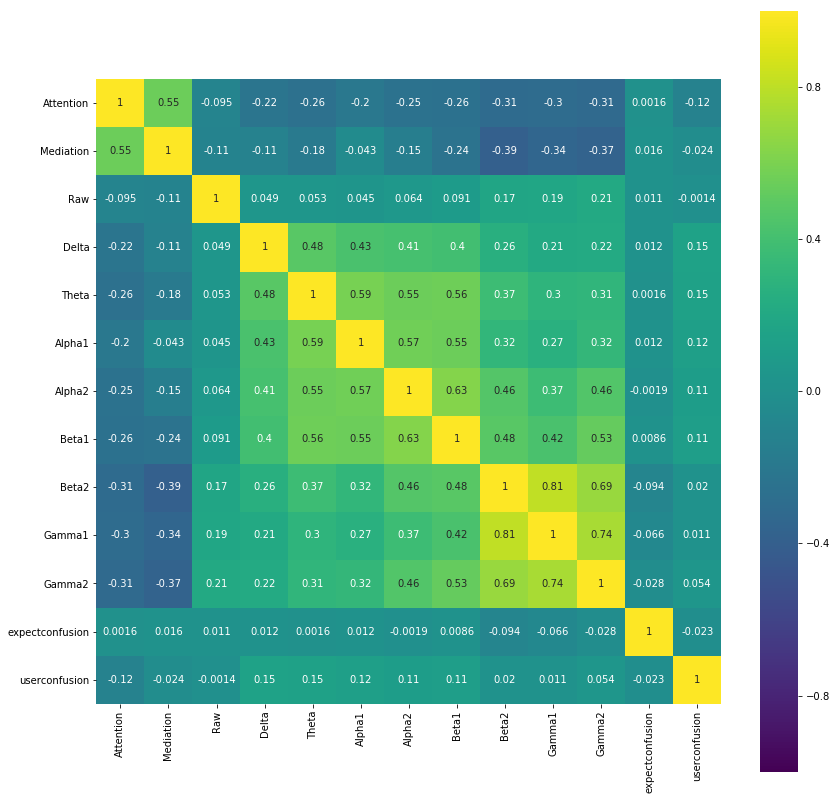

In [107]:
correlation =data.iloc[:,2:].corr()
plt.figure(figsize = (14,14))
sns.heatmap(correlation, vmax= 1, square= True, annot= True, cmap="viridis")

In [6]:
# KEY: 0=F, 1=M
data['Gender']= None
for idx, row in data.iterrows():
    if row['Subject ID'] == 3 or row['Subject ID'] == 9:
        data.loc[idx, 'Gender'] = 0
    else:
        data.loc[idx, 'Gender'] = 1

In [7]:
# KEY: 0=CHINESE, 1=ENGLISH, 2= INDIAN
data['Ethnicity']= None
for idx, row in data.iterrows():
    if row['Subject ID'] == 2:
        data.loc[idx, 'Ethnicity'] = 1
    elif  row['Subject ID'] == 4:
        data.loc[idx, 'Ethnicity'] = 2
    else:
        data.loc[idx, 'Ethnicity'] = 0

In [8]:
data['Age']= None
for idx, row in data.iterrows():
    if row['Subject ID'] == 2:
        data.loc[idx, 'Age'] = 31        
    elif  row['Subject ID'] == 3:
        data.loc[idx, 'Age'] = 28        
    else:
        data.loc[idx, 'Age'] = 24        

In [9]:
data.head()

,Subject ID,Video ID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,expectconfusion,userconfusion,Gender,Ethnicity,Age
0,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,1,0,24
1,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,1,0,24
2,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,1,0,24
3,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,1,0,24
4,0.0,0.0,44.0,66.0,73.0,1786446.0,176766.0,59352.0,26157.0,15054.0,33669.0,33782.0,31750.0,0.0,0.0,1,0,24


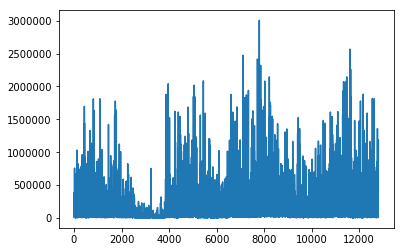

In [10]:
plt.plot(data.Theta)

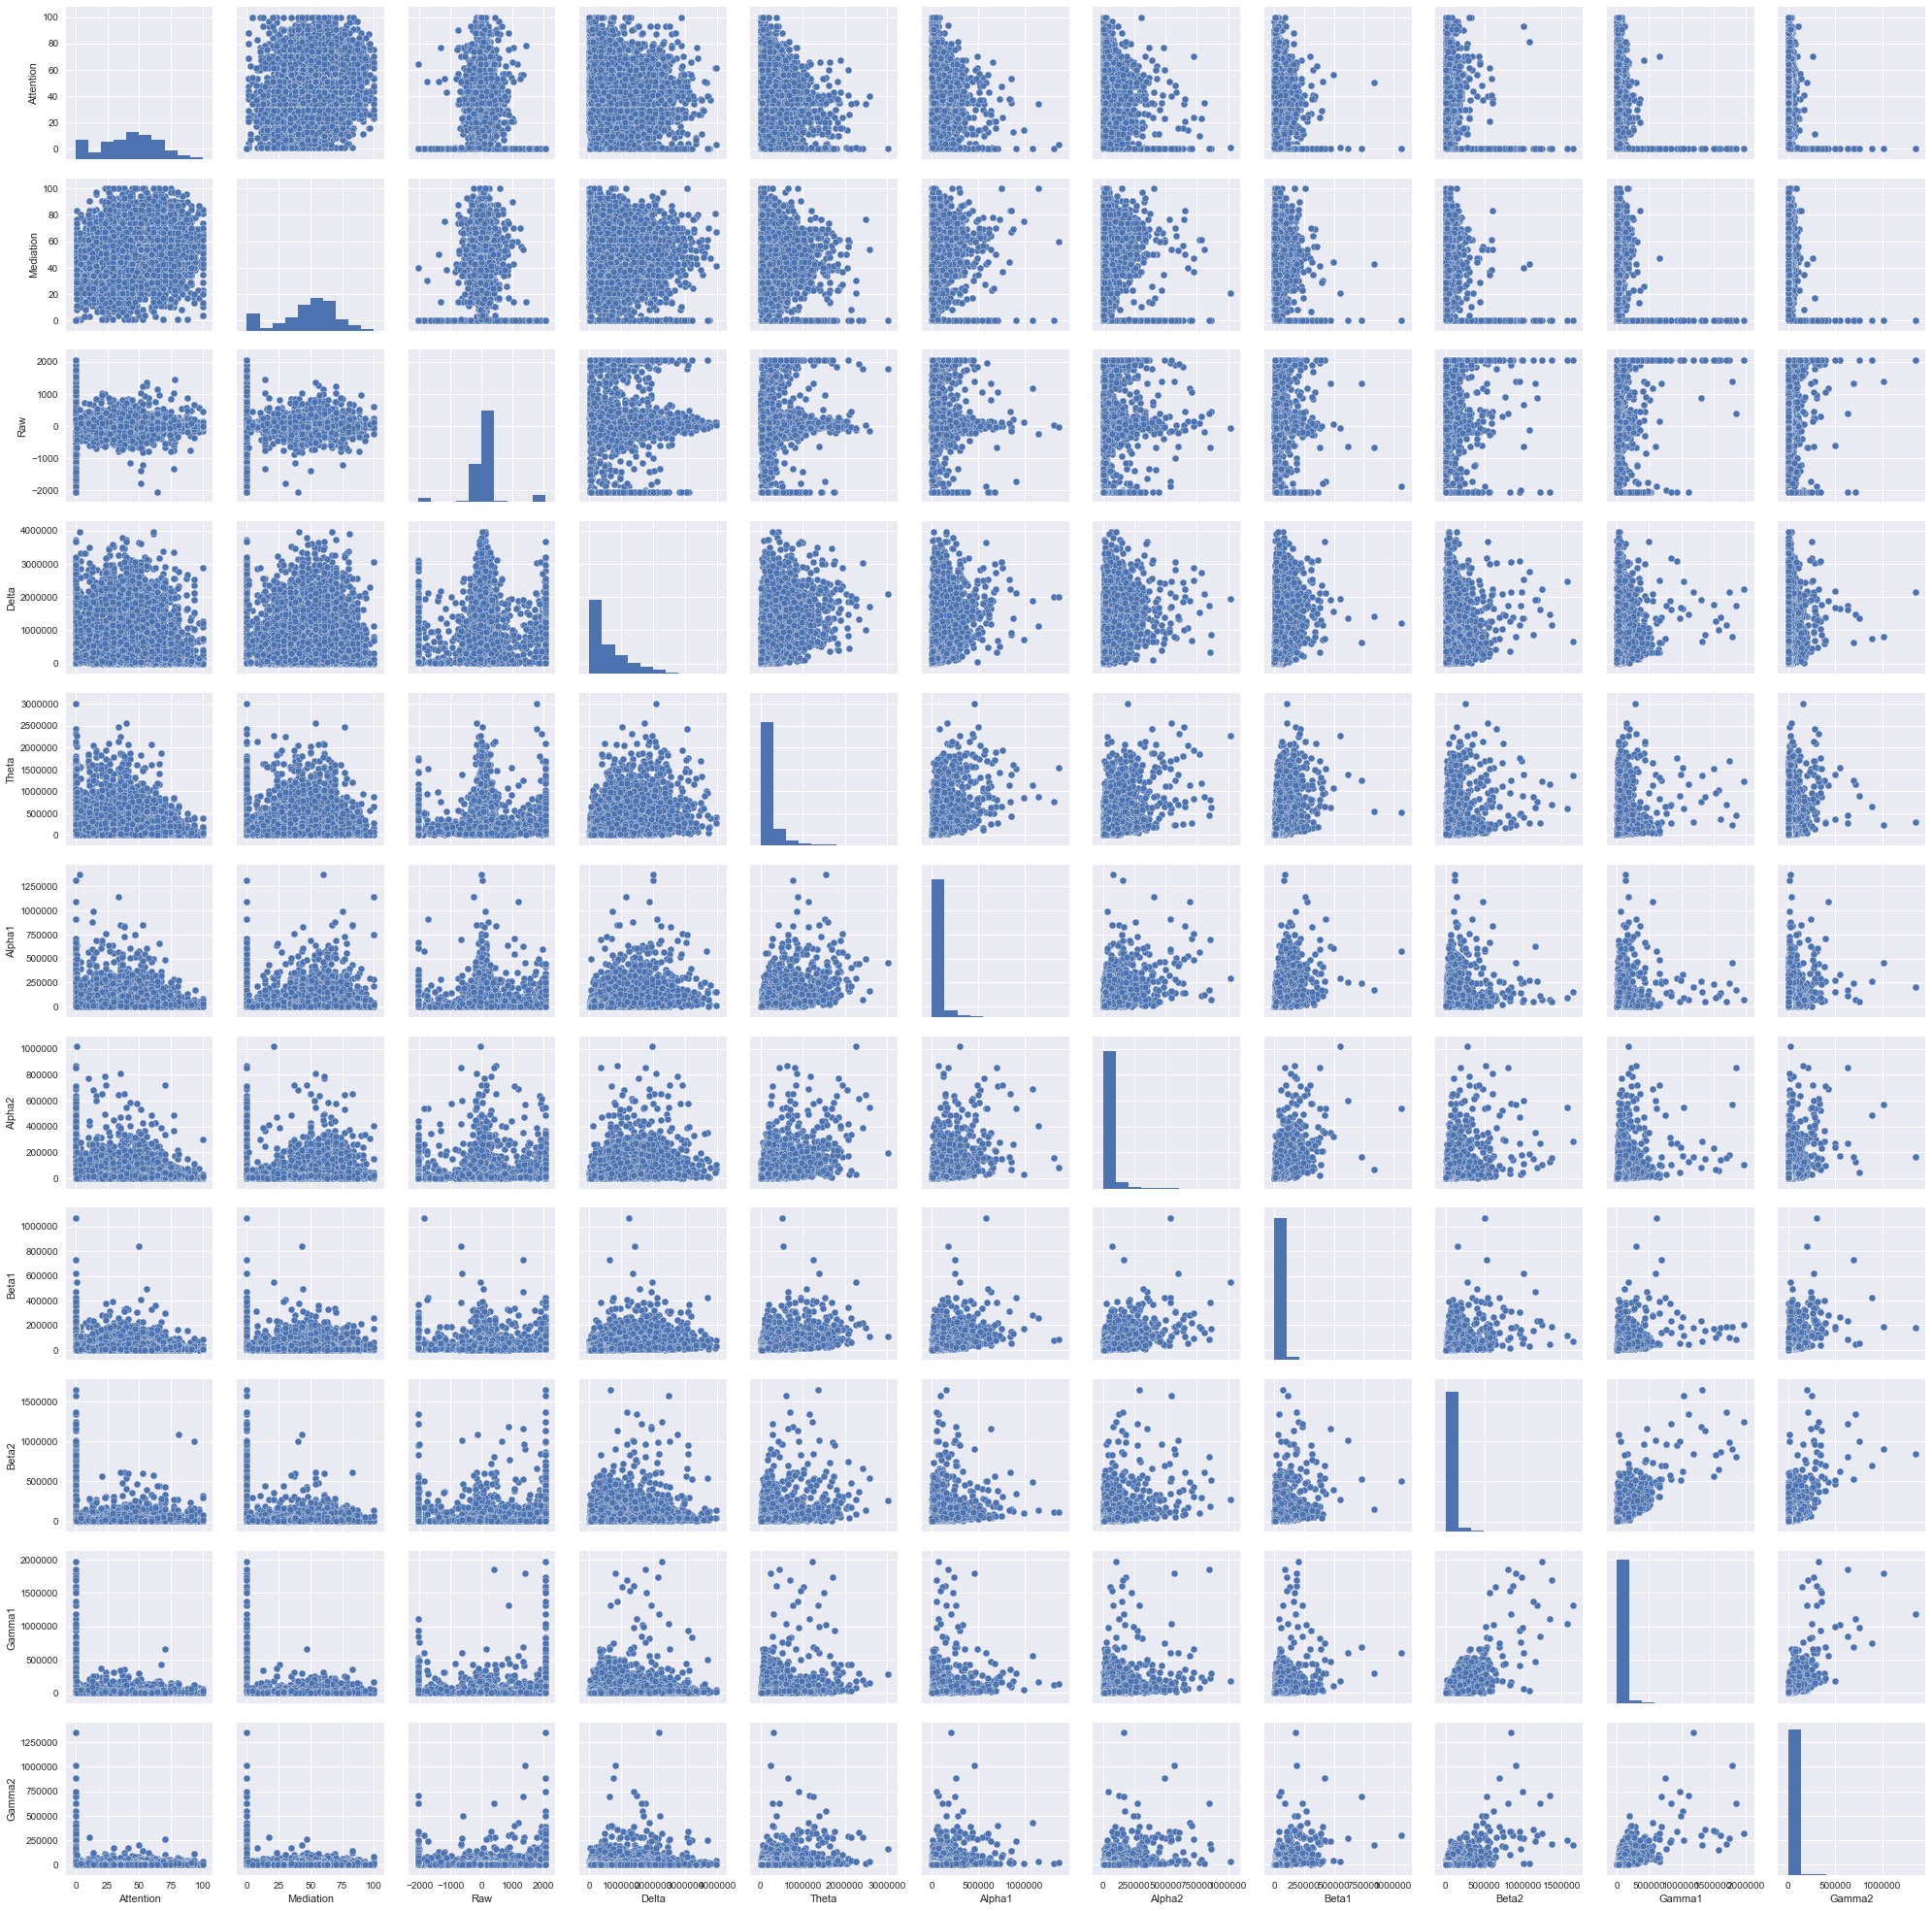

In [13]:
sns.pairplot(data.iloc[:,2:13])

In [ ]:
sns.pairplot(data[8:15])

In [ ]:
# TO DO 

## Fill in some EDA
## Voting Ensemble
## Gradient Boosted Trees
## PCA
## Convert into Spyder

# Write-up

# Precision Recall Curve .. 

In [14]:
train, test = train_test_split(data, test_size= .25, random_state=1)

train_x= train.drop(['userconfusion',"Subject ID","Video ID"], axis=1)
test_x= test.drop(['userconfusion',"Subject ID","Video ID"], axis=1)
train_y = train['userconfusion']
test_y = test['userconfusion']

In [15]:
print("Baseline %")
sum(test_y)/len(test_y)*100

Baseline %


51.045894473930687

## DECISION TREE

In [16]:
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(train_x, train_y)
print("SCORE:")
clf.score(test_x, test_y) *100

SCORE:


62.129253824539497

## FEATURE IMPORTANCE

In [17]:
clf.feature_importances_

array([ 0.19031703,  0.03808118,  0.05918324,  0.27519562,  0.        ,
        0.        ,  0.        ,  0.        ,  0.01609362,  0.16049816,
        0.11013113,  0.        ,  0.03411746,  0.11638256,  0.        ])

In [18]:
# Seems to potentially disprove the contention that 'Theta' waves might attend confusion
#col_headings = col_headings+['Gender','Ethnicity','Age']
feature_importance = pd.DataFrame(clf.feature_importances_, index=train_x.columns)
feature_importance.columns= ["Feature_Importance"]
feature_importance['Feature_Importance']
feature_importance= feature_importance.sort_values("Feature_Importance", axis = 0)

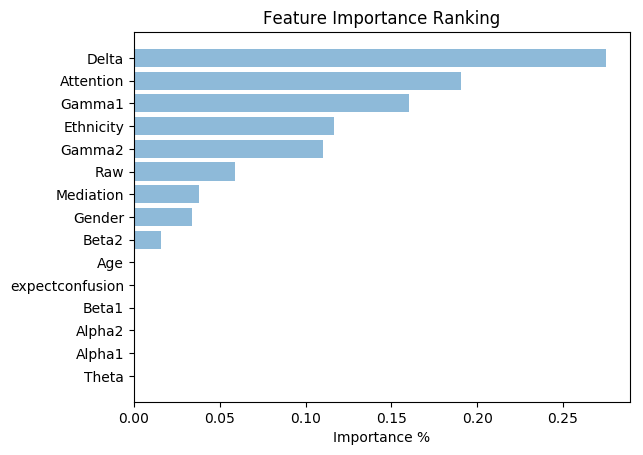

In [19]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = feature_importance.index
y_pos = np.arange(len(feature_importance.index))
performance = feature_importance['Feature_Importance'] 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance %')
plt.title('Feature Importance Ranking')
plt.show()

In [22]:
top_4_features = list(feature_importance['Feature_Importance'][11:].index)
top_4_features_response =  top_4_features+['userconfusion']
data_masked = data[top_4_features_response]
data_masked.head()

,Ethnicity,Gamma1,Attention,Delta,userconfusion
0,0,5293.0,40.0,73787.0,0.0
1,0,57243.0,47.0,758353.0,0.0
2,0,49960.0,47.0,2012240.0,0.0
3,0,44790.0,44.0,1005145.0,0.0
4,0,33782.0,44.0,1786446.0,0.0


In [23]:
# Masking dataframe to acount for top 4 features 
train, test = train_test_split(data_masked, test_size= .25, random_state=1)

train_x_masked= train.drop(['userconfusion'], axis=1)
test_x_masked= test.drop(['userconfusion'], axis=1)
train_y_masked = train['userconfusion']
test_y_masked = test['userconfusion']

In [24]:
# LOSS LESS THAN 1% ACCURACY ...PROBABLY PREFERRABLE CONSIDERING SPARSE SOLUION
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(train_x_masked, train_y_masked)
print("SCORE:")
clf.score(test_x_masked, test_y_masked) *100

SCORE:


61.442397752107404

## PIPELINE

In [25]:
# With Standard Scaler
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])

In [26]:
print(pipe_lr.get_params())

{'clf__min_weight_fraction_leaf': 0.0, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__class_weight': None, 'clf__max_depth': None, 'scl': StandardScaler(copy=True, with_mean=True, with_std=True), 'clf__presort': False, 'steps': [('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))], 'scl__with_mean': True, 'clf__splitter': 'best', 'clf__random_state': None, 'clf__criterion': 'gini', 'clf__min_samples_split': 2, 'scl__copy': True, 'scl__with_std': True, 'clf__min_impurity_split': 1e-07, 'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_

## Validation Curves

In [27]:
from sklearn.learning_curve import validation_curve 

param_range = [2, 4, 6, 8, 10, 12]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=train_x_masked, y=train_y_masked,
                                             param_name='clf__max_depth', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

/Users/anaconda/envs/dan_ty/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


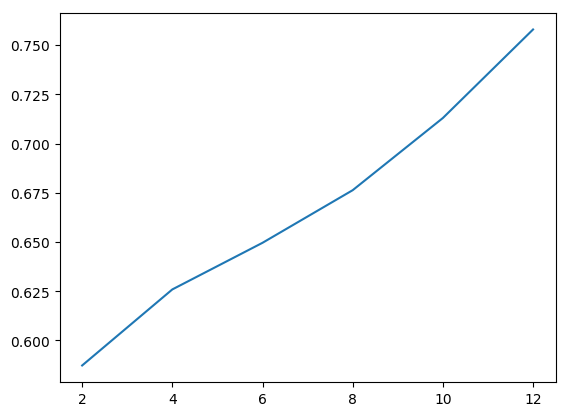

In [28]:
plt.plot(param_range, train_mean, label='Training_Accuracy')

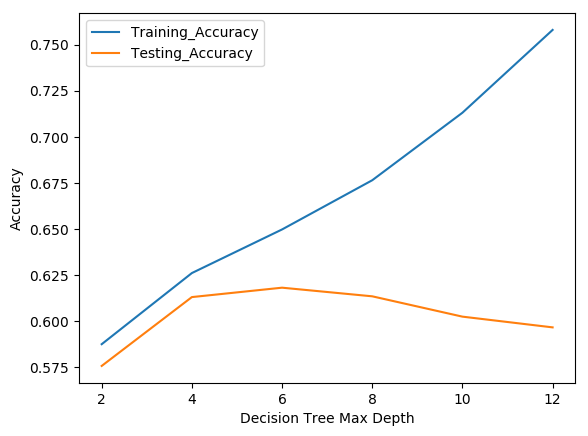

In [30]:
# Conclusion >> Max_Depth of 6 (or possibly 4) is ideal  .. Anything greater clear evidence of overfit
plt.plot(param_range, train_mean, label='Training_Accuracy')
plt.plot(param_range, test_mean, label='Testing_Accuracy')
plt.xlabel('Decision Tree Max Depth')
plt.legend()
plt.ylabel('Accuracy')

## GRID SEARCH

In [31]:
gs = GridSearchCV(
    estimator= DecisionTreeClassifier(random_state=0),
    param_grid= [{'max_depth':[2,4,6,8,10,None]}],
    scoring= 'accuracy',
    cv= 10)

scores = cross_val_score(gs, train_x, train_y, scoring='accuracy', cv=10)

In [32]:
print('CVAccuracy: %.3f+/- %.3f' %(np.mean(scores)*100, np.std(scores)))

CVAccuracy: 65.567+/- 0.013


## PERFORMANCE METRICS AND ROC 

In [33]:
# Generate Confusion Matrix

print('Precision: %.3f', precision_score(y_true= test_y_masked, y_pred= clf.predict(test_x_masked))*100) 
print('Recall: %.3f', recall_score(y_true= test_y_masked, y_pred= clf.predict(test_x_masked)) *100)
print('F1: %.3f', f1_score(y_true= test_y_masked, y_pred= clf.predict(test_x_masked))*100) 
print('AUC: %.3f', roc_auc_score(y_true= test_y_masked, y_score= clf.predict(test_x_masked))*100)

Precision: %.3f 59.3457943925
Recall: %.3f 77.6758409786
F1: %.3f 67.2847682119
AUC: %.3f 61.0955735505


## LOGISTIC REGRESSION

In [34]:
lr_eeg=  LogisticRegression()
lr_eeg.fit(train_x, train_y)
lr_score= lr_eeg.score(train_x, train_y)*100
lr_score

60.154054335380444

In [35]:
# Compute confusion matrix
print("Confusion Matrix ")
print("Classif: 0    1")
confusion_matrix(y_true=test_y, y_pred=lr_eeg.predict(test_x))

Confusion Matrix 
Classif: 0    1


array([[935, 633],
       [660, 975]])

## LEARNING CURVE

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.learning_curve import learning_curve


train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(penalty ='l2'),X= train_x, y= train_y, 
                                    train_sizes = [1000,2000,4000,6000,8000], cv= 10, n_jobs=1)
train_mean =  np.mean(train_scores, axis= 1)
train_std = np.std(train_scores, axis= 1)
test_mean = np.mean(test_scores, axis= 1)
test_std = np.std(test_scores, axis= 1)

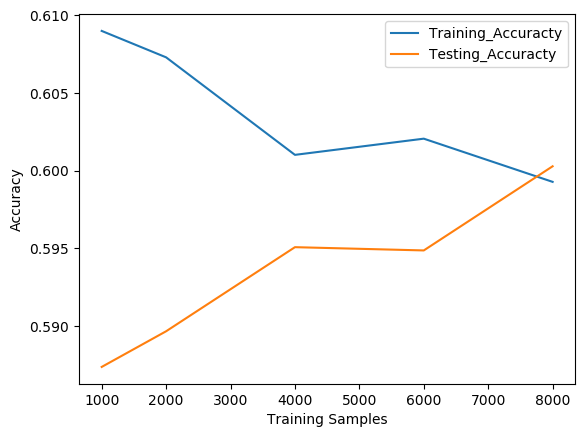

In [37]:
plt.plot(train_sizes, train_mean, label='Training_Accuracty')
plt.plot(train_sizes, test_mean, label='Testing_Accuracty')
plt.xlabel('Training Samples')
plt.legend()
plt.ylabel('Accuracy')

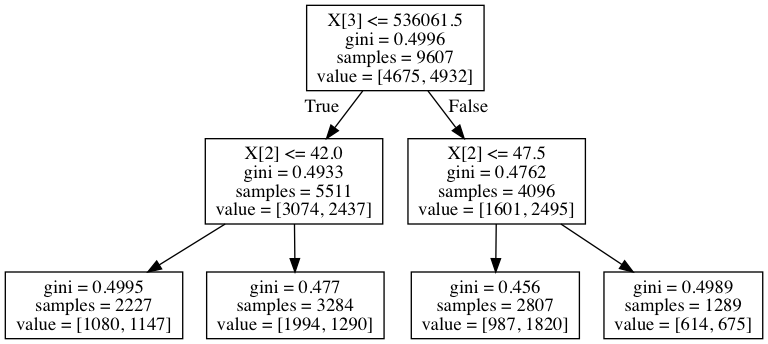

In [512]:
clf.set_params(max_depth=2).fit(train_x_masked, train_y_masked)
dot_data= tree.export_graphviz(clf, out_file= None)

graph= pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("EEG_TREE_CLASSIFIER") 
Image(graph.create_png())

## RandomForest

In [41]:
xlabels = []
n_trees = []
for i in range(50,500, 50):
    eeg_rf = RandomForestClassifier(n_estimators=i, max_features=4, random_state=1)
    eeg_rf.fit(train_x, train_y)
    n_trees.append(eeg_rf.score(test_x, test_y)*100)
    xlabels.append(i)

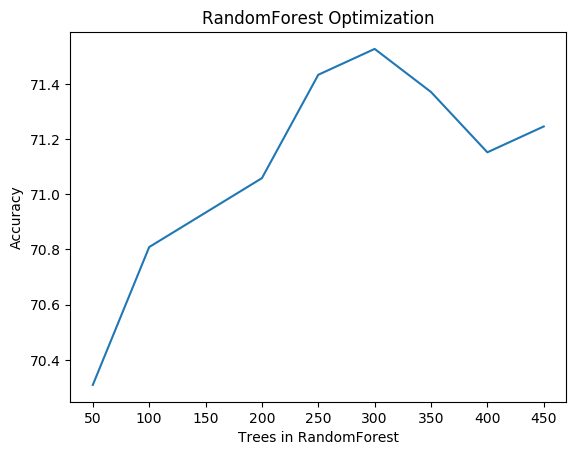

In [536]:
# Implies 300 Trees Generates the Highest Accuracy
plt.plot(xlabels, n_trees)
plt.xlabel('Trees in RandomForest')
plt.ylabel('Accuracy')
plt.title("RandomForest Optimization")

#RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, #min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, #oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [514]:
# Why does this decision path look like its got more features than 5 ?
print(eeg_rf.score(test_x, test_y)*100)
eeg_rf.decision_path(test_x)

71.0583827662


(<3203x648198 sparse matrix of type '<class 'numpy.int64'>'
 	with 9752574 stored elements in Compressed Sparse Row format>,
 array([     0,   3221,   6452,   9733,  12978,  16335,  19596,  22921,
         26156,  29383,  32708,  35967,  39122,  42427,  45640,  48869,
         52022,  55311,  58552,  61779,  64984,  68241,  71486,  74767,
         78010,  81249,  84520,  87755,  90956,  94227,  97450, 100617,
        103840, 107111, 110452, 113759, 116936, 120197, 123354, 126531,
        129724, 132885, 136214, 139531, 142718, 146061, 149332, 152459,
        155722, 159047, 162290, 165599, 168798, 172063, 175290, 178575,
        181710, 184961, 188144, 191371, 194542, 197729, 200930, 204163,
        207378, 210667, 213898, 217077, 220314, 223537, 226778, 229941,
        233248, 236467, 239692, 242939, 246180, 249343, 252422, 255665,
        258968, 262155, 265406, 268673, 272058, 275283, 278438, 281757,
        284932, 288145, 291438, 294627, 297848, 301101, 304340, 307583,
        310

## Ensemble Classifiers

In [64]:
# Voting Classifier ... Accuracy lower than RandomForest (with 500 trees) ...possible ?
voting = VotingClassifier(estimators=[('lr', lr_eeg), ('rf', eeg_rf), ('gnb', clf)], voting='hard')
voting = voting.fit(train_x_masked, train_y_masked)
print("Confusion Matrix ")
print("Classif: 0    1")
print(confusion_matrix(y_true=test_y_masked, y_pred=voting.predict(test_x_masked)))
print()
print("Voting Classifier Accuracy: ")
print((1-(902+289)/(666+902+289+1346))*100)

Confusion Matrix 
Classif: 0    1
[[ 666  902]
 [ 289 1346]]

Voting Classifier Accuracy: 
62.8161098969716


In [58]:
gbc= GradientBoostingClassifier(loss='deviance', learning_rate=0.1,
n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None,
max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')

print("Gradient Boosting Accuracy: ")
gbc.fit(train_x, train_y)
print(gbc.score(test_x, test_y)*100)

Gradient Boosting Accuracy: 
67.0309085233


In [114]:
scaler = StandardScaler()
X = scaler.fit_transform(train_x)
# variances given in descending order ...get labels
pca= PCA()
pca.fit_transform(X)                         
print(train_x.columns)
explained_variance= pca.explained_variance_ratio_
pca.explained_variance_ratio_

Index(['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2',
       'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'expectconfusion', 'Gender',
       'Ethnicity', 'Age'],
      dtype='object')


array([ 0.31212294,  0.11477547,  0.09011982,  0.07694477,  0.06769581,
        0.06468447,  0.05903831,  0.04058441,  0.03459457,  0.03107981,
        0.03023312,  0.02571002,  0.02304711,  0.01857217,  0.01079721])

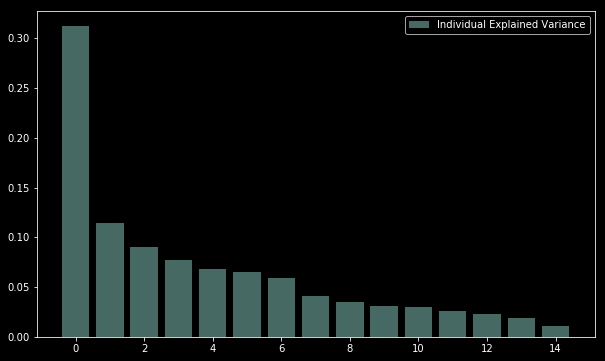

In [128]:
with plt.style.context("dark_background"):
    plt.figure(figsize= (10,6))
    plt.bar(range(len(explained_variance)), explained_variance, alpha=.5, align= "center", label = "Individual Explained Variance")
#    plt.ylabel("Explained Variance")    
#    plt.xlabel("Principal Component")
    plt.legend(loc="best")
    plt.tight_layout()        

In [78]:
pca_model = PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', 
                tol=0.0, iterated_power='auto', random_state=None)

train_x_scaled = scale(train_x)
train_y_scaled = scale(train_y)
#pca_model= pca_model.fit(pipe_lr)
pca_model= pca_model.fit(train_x_scaled, train_y_scaled)
print(train_x.columns)
pca_model.explained_variance_ratio_

Index(['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2',
       'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'expectconfusion', 'Gender',
       'Ethnicity', 'Age'],
      dtype='object')


array([ 0.31212294,  0.11477547,  0.09011982,  0.07694477,  0.06769581,
        0.06468447,  0.05903831,  0.04058441,  0.03459457,  0.03107981,
        0.03023312,  0.02571002,  0.02304711,  0.01857217,  0.01079721])

In [55]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Binarize the output
y = label_binarize(test_y, classes=[0, 1])
# test_y.shape[1]
n_classes = 1

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()


precision, recall, thresholds = precision_recall_curve(test_y, lr_score)


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

Automatically created module for IPython interactive environment


TypeError: Singleton array 60.154054335380444 cannot be considered a valid collection.